# Denoising AutoEncoder

1. CNN+AE
2. CNN+AE+BatchNorm
3. CNN+AE+SSIMLoss

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE
from LossFunction import SSIMLoss #自作Loss関数
import LossFunction

## 学習データ作成

In [2]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("sample_data", "sample_test", 1000, 128, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (1000, 128, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


## モデル学習

Denoise AE


In [3]:

losslist=[]
#model
model_CnnAE = mainmodel.Autoencoder_cnn()#model1
model_norm = mainmodel.Autoencoder_batchnorm()#model2
#loss
criterion_mse = nn.MSELoss()
criterion_ssim = LossFunction.SSIMLoss()

model = model_norm
criterion = criterion_mse

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

outputs = []
#テンソル型に変換
input = torch.from_numpy(data.astype(np.float32)).clone()
ori_input = torch.from_numpy(ori_data.astype(np.float32)).clone()
cnt = 0
for (epoch, epoch_ori) in zip(input, ori_input):
    cnt+=1
    for (x, y) in zip(epoch, epoch_ori):
        recon = model(x)
        # print("type:recon_data{}".format(type(recon)))
        loss = criterion(recon, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch:{}, Loss:{:.4f}'.format(cnt, float(loss)))
    losslist.append(loss)
    outputs.append((epoch, data, recon))

make
epoch:1, Loss:0.1046
epoch:2, Loss:0.0361
epoch:3, Loss:0.0211
epoch:4, Loss:0.0121
epoch:5, Loss:0.0119
epoch:6, Loss:0.0140
epoch:7, Loss:0.0063
epoch:8, Loss:0.0057
epoch:9, Loss:0.0049
epoch:10, Loss:0.0035
epoch:11, Loss:0.0090
epoch:12, Loss:0.0070
epoch:13, Loss:0.0045
epoch:14, Loss:0.0038
epoch:15, Loss:0.0023
epoch:16, Loss:0.0044
epoch:17, Loss:0.0041
epoch:18, Loss:0.0029
epoch:19, Loss:0.0020
epoch:20, Loss:0.0032
epoch:21, Loss:0.0040
epoch:22, Loss:0.0034
epoch:23, Loss:0.0026
epoch:24, Loss:0.0019
epoch:25, Loss:0.0017
epoch:26, Loss:0.0008
epoch:27, Loss:0.0358
epoch:28, Loss:0.0069
epoch:29, Loss:0.0030
epoch:30, Loss:0.0010
epoch:31, Loss:0.0015
epoch:32, Loss:0.0039
epoch:33, Loss:0.0011
epoch:34, Loss:0.0017
epoch:35, Loss:0.0013
epoch:36, Loss:0.0005
epoch:37, Loss:0.0012
epoch:38, Loss:0.0015
epoch:39, Loss:0.0034
epoch:40, Loss:0.0013
epoch:41, Loss:0.0012
epoch:42, Loss:0.0013
epoch:43, Loss:0.0013
epoch:44, Loss:0.0010
epoch:45, Loss:0.0013
epoch:46, Loss

## モデルの保存

In [4]:
folder_name = "tyuudenkou"
model_name = "Denoising_AE_CNN"
ModelEdit = mainmodel.Modeledit(folder_name,model_name)
ModelEdit.save_model(model)

## 結果の確認

<class 'torch.Tensor'>


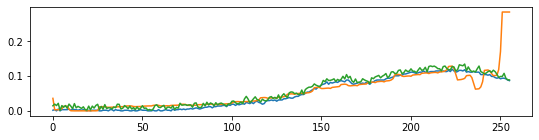

normal:3.296368619743589


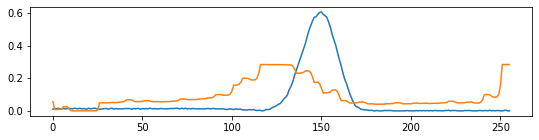

anomarly:25.469468931667507
anomaly
<class 'torch.Tensor'>


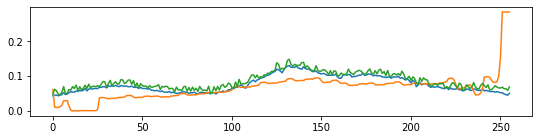

normal:6.582754053175449


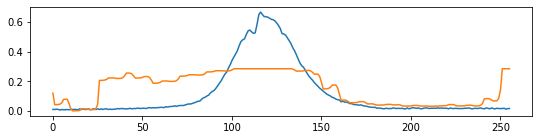

anomarly:26.973805038258433
anomaly
<class 'torch.Tensor'>


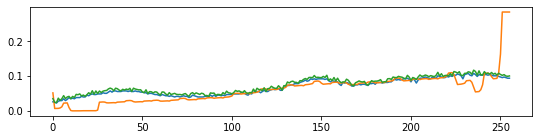

normal:4.162916788831353


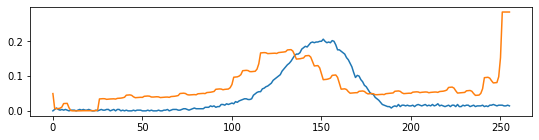

anomarly:12.714221277532488
anomaly
<class 'torch.Tensor'>


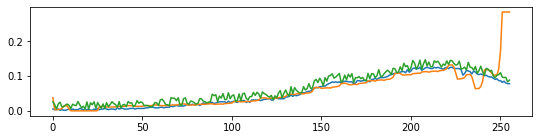

normal:2.8874415485188365


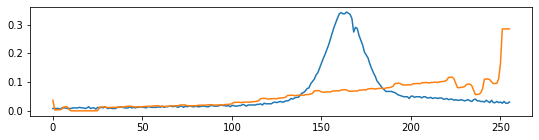

anomarly:11.642086531501263
anomaly
<class 'torch.Tensor'>


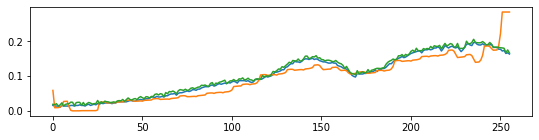

normal:3.958528980612755


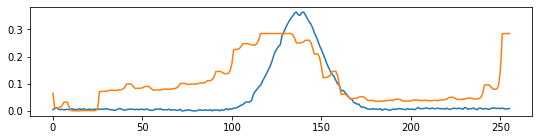

anomarly:18.176345598883927
anomaly
Finish


In [5]:
# num = 5

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        try:
            data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
            input0 =  torch.from_numpy((data[i]).astype(np.float32)).clone()
            ori_input0 =  torch.from_numpy((ori_data[i]).astype(np.float32)).clone()
            # ori_input0 =  ori_data[i]
            test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
            print(type(data0))
            plt.figure(figsize=(9, 2))
            # data = data0.numpy()
            ori_input0 = ori_input0[i, :, :, :]
            input0 = input0[i, :, :, :]
            recon = model(ori_input0).detach().numpy()
            ori_input0 = ori_input0[0, 0, :]
            input0 = input0[0, 0, :]
            plt.plot(ori_input0)
            plt.plot(recon.flatten())
            plt.plot(input0)
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-ori_input0.numpy()))
            print("normal:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
                
            plt.figure(figsize=(9, 2))
            # data = test0.numpy()
            ano_data = test0[np.newaxis, np.newaxis, :]
            recon = model(ano_data).detach().numpy()
            plt.plot(test0.numpy(),label="testdata")
            plt.plot(recon.flatten(),label="recondata")
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
            print("anomarly:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
        except IndexError:
            print("Finish")
            break

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve

# OCSVM

In [7]:
import dataloader
#OCSVM用データセットロード
Dataset = dataset.dataset("Obrid_AE", "data")
data, test_data , anomaly_data= Dataset.read_traindata_ocs("sample_data", "sample_test", 1000, 256, 1)
#モデルの読み込み必要なら
model_name = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211206/newmodel.pth"
input_model = mainmodel.Autoencoder_cnn()
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_model = mainmodel.Autoencoder_cnn().to(device)
input_model.load_state_dict(torch.load(model_name, map_location=device))

# input_model = model
#OCSVM用再構成後データセットロード
recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(input_model, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(input_model, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(input_model, anomaly_data)

(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (450, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)
--------1/450--------
--------2/450--------
--------3/450--------
--------4/450--------
--------5/450--------
--------6/450--------
--------9/450--------
--------10/450--------
--------12/450--------
--------15/450--------
--------18/450--------
--------20/450--------
--------25/450--------
--------30/450--------
--------36/450--------
--------45/450--------
--------50/450--------
--------60/450--------
--------75/450--------
--------90/450--------
--------100/450--------
--------150/450--------
--------180/450--------
--------225/450--------
--------250/450--------
--------300/450--------
recon_list:(450, 256)
encoded_list:(450, 3)
input_list:(450,)
--------1/50--------
--------2/50--------
--------4/50--------
--------5/50--------
--------10/50--------
--------20/50--------
--------25/50--------
recon_list:(50, 256)
encoded_list:(50, 3)
input_list:(50,)
----

/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/dataloader.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  input_list = np.array(input_list)
/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/dataloader.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_list = np.array(input_list)


## 可視化

y_pred_train:450 
y_pred_anomaly:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1] 
y_pred_outliers:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 


/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_3682/2985198829.py:62: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_3682/2985198829.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


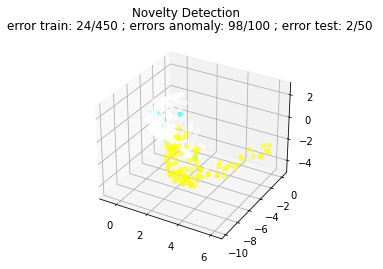

In [8]:
from sklearn.svm import OneClassSVM

X_anomaly = anomaly_encoded_list
X_test = test_encoded_list
X_train = encoded_list

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from sklearn import svm
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

SPACE_SAMPLING_POINTS = 100
TRAIN_POINTS = 100

# Define the size of the space which is interesting for the example
X_MIN = -100
X_MAX = 100
Y_MIN = -100
Y_MAX = 100
Z_MIN = -100
Z_MAX = 100

# Generate a regular grid to sample the 3D space for various operations later
xx, yy, zz = np.meshgrid(np.linspace(X_MIN, X_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Y_MIN, Y_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Z_MIN, Z_MAX, SPACE_SAMPLING_POINTS))

# Generate some abnormal novel observations using a different distribution
X_outliers = np.random.uniform(low=-10, high=10, size=(20, 3))

# Create a OneClassSVM instance and fit it to the data
clf = svm.OneClassSVM(nu=0.009, kernel="rbf", gamma=0.8)
clf.fit(X_train)
# Predict the class of the various input creaxted before
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_anomaly = clf.predict(X_anomaly)
# y_pred_normal = clf.predict(X_anomaly)
y_pred_outliers = clf.predict(X_outliers)
print("y_pred_train:{} ".format(y_pred_train.shape[0] ))
print("y_pred_anomaly:{} ".format(y_pred_anomaly ))
print("y_pred_outliers:{} ".format(y_pred_outliers ))
# And compute classification error frequencies
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_anomaly = y_pred_anomaly[y_pred_anomaly == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
error_train = y_pred_train[y_pred_train == -1]
error_anomaly = y_pred_anomaly[y_pred_anomaly == -1]
error_test = y_pred_test[y_pred_test == 1]
# Calculate the distance from the separating hyperplane of the SVM for the
# whole space using the grid defined in the beginning
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)

# Create a figure with axes for 3D plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle("Novelty Detection")

# Plot the different input points using 3D scatter plotting
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='white', alpha=0.5)
# ax.scatter(error_train[:, 0],error_train[:, 1], error_train[:, 2], c='black', alpha=0.5)
b2 = ax.scatter(X_anomaly[:, 0], X_anomaly[:, 1], X_anomaly[:, 2], c='yellow', alpha=0.5)
# ax.scatter(error_anomaly[:, 0],error_anomaly[:, 1], error_anomaly[:, 2], c='red', alpha=0.5)
c = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='cyan', alpha=0.5)
# ax.scatter(error_test[:, 0],error_test[:, 1], error_test[:, 2], c='magenta', alpha=0.5)
# Plot the separating hyperplane by recreating the isosurface for the distance
# == 0 level in the distance grid computed through the decision function of the
# SVM. This is done using the marching cubes algorithm implementation from
# scikit-image.
# verts, faces = measure.marching_cubes(Z, 0)
# # Scale and transform to actual size of the interesting volume
# verts = verts * \
#     [X_MAX - X_MIN, Y_MAX - Y_MIN, Z_MAX - Z_MIN] / SPACE_SAMPLING_POINTS
# verts = verts + [X_MIN, Y_MIN, Z_MIN]
# # and create a mesh to display
# mesh = Poly3DCollection(verts[faces],
#                         facecolor='orange', edgecolor='gray', alpha=0.3)
# ax.add_collection3d(mesh)

# # Some presentation tweaks
# ax.set_xlim((-5, 5))
# ax.set_ylim((-5, 5))
# ax.set_zlim((-5, 5))

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.legend([mpatches.Patch(color='orange', alpha=0.3), b1, b2, c],
#     ["learned frontier", "training observations",
#     "new regular observations", "new abnormal observations"],
#     loc="lower left",
#     prop=matplotlib.font_manager.FontProperties(size=11))
ax.set_title(
    "error train: %d/%d ; errors anomaly: %d/%d ; "
    "error test: %d/%d "
    % (n_error_train, X_train.shape[0], n_error_anomaly, X_anomaly.shape[0], n_error_test, X_test.shape[0]))
fig.show()